## 특징 간 상관성 제거
- 선형식이 모델에 포함되는 경우, 특징간 상관성이 높으면 파라미터 추정이 어려움
- 트리계열의 모델은 상관없지만, 상관성이 높은 변수 중 소수만 모델에 포함되므로 설명력에 영향
- VIF 활용
    - 한 특징을 라벨로 간주하고, 다른 특징을 사용한 회귀 모델이 높은 R^2을 보이는 경우 해당 특징과 다른 특징이 상관이 있다고 판단
    - VIF가 높은 순서대로 제거하거나, 10이상인 경우 주로 삭제
- 주성분 분석
    - 특징이 서로 직교하도록 만들어 특징간 상관성을 줄임
    - 차원 축소 등을 위해 분산의 대부분을 설명하는 주성분만 사용
    - sklearn.decomposition.PCA : 주성분 분석을 수행하는 인스턴스를 생성
    - n_components : 사용할 주성분 개수, 기존 차원 수보다 작아야함
    - .explained_variance_ratio_ : 각 주성분이 원 데이터의 분산을 설명하는 정도

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
df = pd.read_csv('./데이터/abalone.csv')
x = df.drop(['Age'], axis = 1)
y = df['Age']

train_x, test_x, train_y, test_y = train_test_split(x,y)
train_x.corr() # 특징 간 상관 행렬 출력

,Length,Diameter,Height,Wholeweight,Shuckedweight,Visceraweight,Shellweight
Length,1.000000,0.986156,0.813865,0.924023,0.897852,0.902204,0.894631
Diameter,0.986156,1.000000,0.819723,0.924217,0.893522,0.898785,0.901945
Height,0.813865,0.819723,1.000000,0.804134,0.761199,0.783753,0.800333
Wholeweight,0.924023,0.924217,0.804134,1.000000,0.968871,0.967362,0.953649
Shuckedweight,0.897852,0.893522,0.761199,0.968871,1.000000,0.933867,0.880542
Visceraweight,0.902204,0.898785,0.783753,0.967362,0.933867,1.000000,0.905861
Shellweight,0.894631,0.901945,0.800333,0.953649,0.880542,0.905861,1.000000


#### VIF 기준 특징 선택

In [11]:
from sklearn.linear_model import LinearRegression as LR
VIF_dict = dict()
for col in train_x.columns:
    model = LR().fit(train_x.drop([col], axis = 1), train_x[col])
    r2 = model.score(train_x.drop([col], axis = 1), train_x[col])
    VIF = 1/(1-r2)
    VIF_dict[col] = VIF

In [12]:
VIF_dict # Height를 제외하고 모두 높으므로, 이러한 상황은 PCA를 사용하기 힘듬

{'Length': 38.797203451394026,
 'Diameter': 39.68876911674904,
 'Height': 3.272537093604633,
 'Wholeweight': 102.65654493866755,
 'Shuckedweight': 26.720652444984033,
 'Visceraweight': 17.690180168670846,
 'Shellweight': 19.70904501826583}

In [13]:
from sklearn.neural_network import MLPRegressor as MLP
from sklearn.metrics import mean_absolute_error as MAE

# 전체 특징을 모두 사용했을 때
model = MLP(random_state = 2313, max_iter=500)
model.fit(train_x, train_y)
pred_y = model.predict(test_x)
score = MAE(test_y, pred_y)
print(score)

1.5747111371547502


In [15]:
# VIF 점수가 30점 미만인 특징만 사용하였을 때
selected_features = [key for key, val in VIF_dict.items() if val < 30]
model = MLP(random_state = 2313, max_iter=500)
model.fit(train_x[selected_features], train_y)
pred_y = model.predict(test_x[selected_features])
score = MAE(test_y, pred_y)
print(score)

1.5340330824321546


c:\users\82106\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


#### PCA 사용

In [16]:
from sklearn.decomposition import PCA
PCA_model = PCA(n_components = 3).fit(train_x)

train_z = PCA_model.transform(train_x)
test_z = PCA_model.transform(test_x)

print(train_z.shape)

(3132, 3)


In [18]:
model = MLP(random_state = 2313, max_iter=500)
model.fit(train_z, train_y)
pred_y = model.predict(test_z)
score = MAE(test_y, pred_y)
print(score)

1.4743285738629737


# 변수 치우침 제거
- 치우친 반대 방향의 값들이 이상치처럼 작용할 수 있으므로, 치우침 제거
- 왜도 : 1.5 이상이면 치우쳤다 판단
- scipy.stats
#### 해결방안
- 값 간 차이를 줄임 : log, sqrt

In [19]:
import pandas as pd
df = pd.read_csv('./데이터/Sonar_Mines_Rocks.csv')
x = df.drop('Y', axis = 1)
y = df['Y']

train_x, test_x, train_y, test_y = train_test_split(x,y)
train_x.skew() # 왜도 확인 -> band60의 왜도가 가장 큼

Band1     2.042964
Band2     1.399994
Band3     1.681616
Band4     1.755210
Band5     1.466803
Band6     1.183945
Band7     1.039505
Band8     1.506274
Band9     1.685665
Band10    1.363778
Band11    1.002877
Band12    0.611954
Band13    0.648960
Band14    1.048454
Band15    0.813608
Band16    0.688193
Band17    0.657626
Band18    0.530925
Band19    0.324271
Band20   -0.056133
Band21   -0.167111
Band22   -0.425375
Band23   -0.673283
Band24   -0.698164
Band25   -0.728501
Band26   -0.633645
Band27   -0.585871
Band28   -0.604747
Band29   -0.521568
Band30   -0.153076
Band31    0.284545
Band32    0.288575
Band33    0.316783
Band34    0.562131
Band35    0.597430
Band36    0.575752
Band37    0.668305
Band38    1.116251
Band39    0.973450
Band40    0.846760
Band41    0.927124
Band42    0.923569
Band43    0.813322
Band44    1.252679
Band45    1.454454
Band46    1.638958
Band47    1.602292
Band48    1.304485
Band49    1.375417
Band50    1.816929
Band51    1.736650
Band52    1.618928
Band53    1.

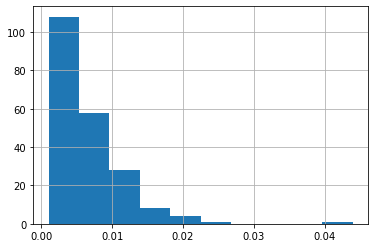

In [20]:
%matplotlib inline
df['Band60'].hist()

#### 치우침을 제거했을 때의 성능 비교를 위한 모델 개방

In [22]:
# 라벨 숫자로 바꾸기
train_y.replace({'M':-1, 'R':1}, inplace = True)
test_y.replace({'M':-1, 'R':1}, inplace = True)

In [24]:
# 원본 데이터로 모델링
from sklearn.metrics import f1_score
from sklearn.neural_network import MLPClassifier as MLP
model = MLP(random_state = 153, max_iter = 1000).fit(train_x, train_y)
pred_y = model.predict(test_x)
score = f1_score(test_y, pred_y)
print(score)

0.761904761904762


In [25]:
# 왜도 기반 치우친 변수 제거
biased_variables = train_x.columns[train_x.skew().abs() > 1.5]

In [27]:
import numpy as np
# 치우침 제거
train_x[biased_variables] = train_x[biased_variables] - train_x[biased_variables].min() + 1
train_x[biased_variables] = np.log10(train_x[biased_variables])

In [28]:
# 치우침 제거 후 모델 평가
model = MLP(random_state = 153, max_iter = 1000).fit(train_x, train_y)

# 테스트도 데이터도 같은 방법으로 전처리 수행
test_x[biased_variables] = test_x[biased_variables] - test_x[biased_variables].min() + 1
test_x[biased_variables] = test_x[biased_variables].apply(np.log)

pred_y = model.predict(test_x)
score = f1_score(test_y, pred_y)
print(score)

0.761904761904762


c:\users\82106\appdata\local\programs\python\python38\lib\site-packages\pandas\core\frame.py:3636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


# 스케일링

- 특징 간 스케일이 달라서 발생하는 문제
- 스케일이 큰 변수에 영향 받는 모델 : k-최근접 이웃
- 스케일이 작은 변수에 영향 받는 모델 : 회귀모델, SVM, 신경망
- 스케일에 영향을 받지 않는 모델 : 나이브베이즈, 의사결정나무(이진)
- 해결방법
    - Standard Scaler - 특징의 정규분포를 가정(회귀) 
    - Min-Max Scaler - 특정 분포를 가정하지 않음(신경망, k-최근접이웃)

- fit : 변수별 통계량을 계산하여 저장
- transform : 변수별 통계량을 바탕으로 스케일링 수행
- inverse_transform : 스케일링된 값을 다시 원래 값으로 변환

In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
df = pd.read_csv('./데이터/baseball.csv')
x = df.drop('Salary', axis = 1)
y = df['Salary']
train_x, test_x, train_y, test_y = train_test_split(x,y)

In [31]:
train_x.max() - train_x.min() # 특징 간 스케일 차이가 큼을 확인

Batting_average              0.394
On-base_percentage           0.423
Runs                       133.000
Hits                       215.000
Doubles                     46.000
Triples                     15.000
HomeRuns                    44.000
Runs_batted_in             122.000
Walks                      108.000
Strike-Outs                174.000
Stolen_bases                72.000
Errors                      27.000
Free_agency_eligibility      1.000
Free_agent                   1.000
Arbitration_eligibility      1.000
Arbitration                  1.000
dtype: float64

In [33]:
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.metrics import mean_absolute_error as MAE
model = KNN().fit(train_x, train_y)
pred_y = model.predict(test_x)
score = MAE(test_y, pred_y)
print(score)

706.5529411764705


In [35]:
# 스케일링 수행
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(train_x)
s_train_x = scaler.transform(train_x)
s_test_x = scaler.transform(test_x)

In [36]:
model = KNN().fit(s_train_x, train_y)
pred_y = model.predict(s_test_x)
score = MAE(test_y, pred_y)
print(score)

503.22588235294126
